We will learn about how to analyze the time series data for finding the periodicity in data of a X-ray Pulsar. We will also see how to do epoch folding the light curve to recover pulsar signature.

You can read more about radio pulsars here: https://www.space.com/32661-pulsars.html

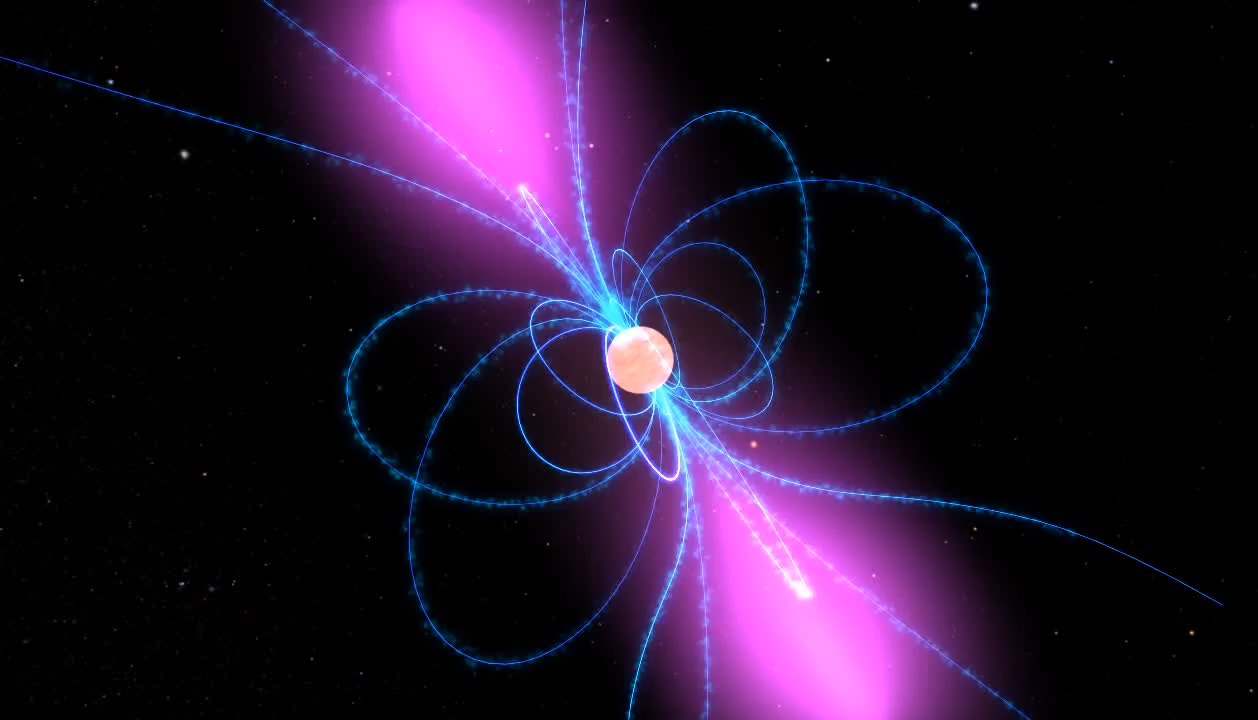

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from astropy.time import Time
from astropy.timeseries import TimeSeries
import warnings
warnings.filterwarnings("ignore")
from astropy.io import fits

Now that we have imported lets open a LC file or a **Light Curve** file

In [18]:
hdul = fits.open('Cen_X-3.lc')
hdul.info()

Filename: Cen_X-3.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   ()      
  1  RATE          1 BinTableHDU     66   20000R x 3C   [D, E, E]   


Let's see the data stored, but first explore the header

In [19]:
hdul[1].header #represents the header(data) of RATE.column names and datatypes are mentioned

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   16 / width of table in bytes                        
NAXIS2  =                20000 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time elapsed since MJDREF                      
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '        

In [20]:
hdul[1].data['RATE'] #gives the rate data. for example 56 photons come per sec

array([ 56.142532, 258.78247 ,  56.15126 , ..., 258.41763 , -46.159744,
       156.88309 ], dtype='>f4')

In [21]:
time = hdul[1].data['TIME']
rate = hdul[1].data['RATE']
print(len(time))
print(time[0],time[1],time[2],time[3])

20000
193385062.81629777 193385062.82629848 193385062.83629924 193385062.84629995


In [22]:
exposure = time[-1] - time[0] #how long our telescope was exposed to the pulsar. ending time-starting time
print('Exposure (in sec)',exposure)
timeres = time[2] - time[1]
print('\nTime Resolution (in sec)',timeres)#time res here is 0.01 so the readings in the graph is taken every 0.01 sec. to solve this binning done

Exposure (in sec) 200.00447911024094

Time Resolution (in sec) 0.010000765323638916


In [23]:
plt.figure(figsize=(16,8))
plt.plot(time,rate)
plt.title('Light Curve')
plt.grid()
plt.xlabel('Time(s)')
plt.ylabel('Count/s')

Text(0, 0.5, 'Count/s')

### Binning of light curve
Bin size needs to be large enough for sufficient number of counts per bin but small enough so that real variation is not hidden

In [24]:

def lc_binning(time, rate, binsize=2): #instead of 0.01 sec give data every 2 sec
    bins = np.arange(time[0], time[-1], binsize) #creates array from time[0] till time[-1] with stepsize of 2 i.e binsize
    digitized = np.digitize(time, bins)#here if time=[0,1,2,3,4] and bins=[0,2,4,6,8] then o/p will be [1,1,2,2,3] as 0 and 1 go in bin1,2 and3 go in bin2 and 4 goes in bin3

    abs_time_bin = np.array([time[digitized == i].mean() if len(time[digitized == i]) > 0 else np.nan for i in range(1, len(bins))]) #can find what data points come in which bins
    un_time_bin = abs_time_bin - abs_time_bin[0]

    un_rate_bin = np.array([rate[digitized == i].mean() if len(rate[digitized == i]) > 0 else np.nan for i in range(1, len(bins))]) #rate corresponding to the bin

    # Keep only indices where both time and rate are not NaN
    mask = ~np.isnan(un_time_bin) & ~np.isnan(un_rate_bin)

    time_bin = un_time_bin[mask] #applying the mask to the arrays
    rate_bin = un_rate_bin[mask] #applying the mask to the arrays

    return time_bin, rate_bin


Text(0, 0.5, 'Count/s')

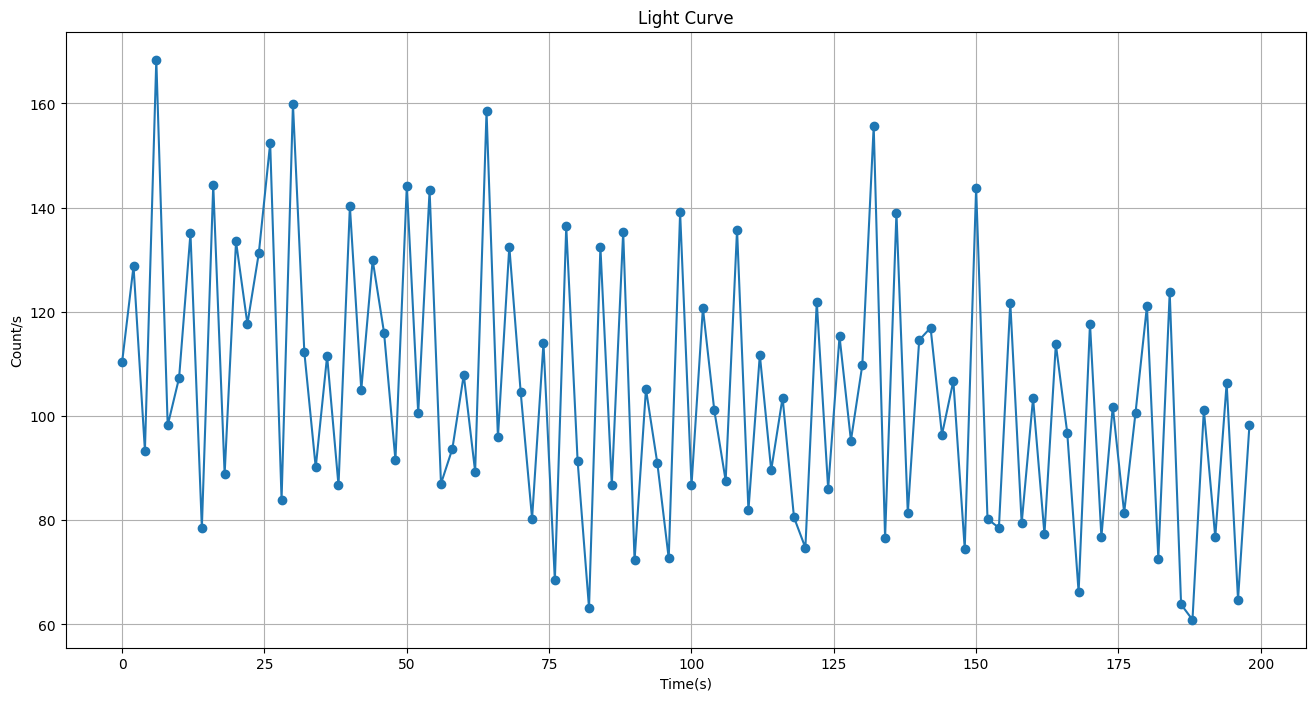

In [220]:
%matplotlib inline
time_bin,rate_bin=lc_binning(time,rate,2)
plt.figure(figsize=(16,8))
plt.plot(time_bin,rate_bin,'-o')
plt.title('Light Curve')
plt.grid()
plt.xlabel('Time(s)')
plt.ylabel('Count/s')

Power vs frequency

To see, whether the time series has any periodicity detection

In [221]:
fft = np.fft.fft(rate)
power = np.array(abs(fft))
frequency=[i/exposure for i in range(0,len(power))]


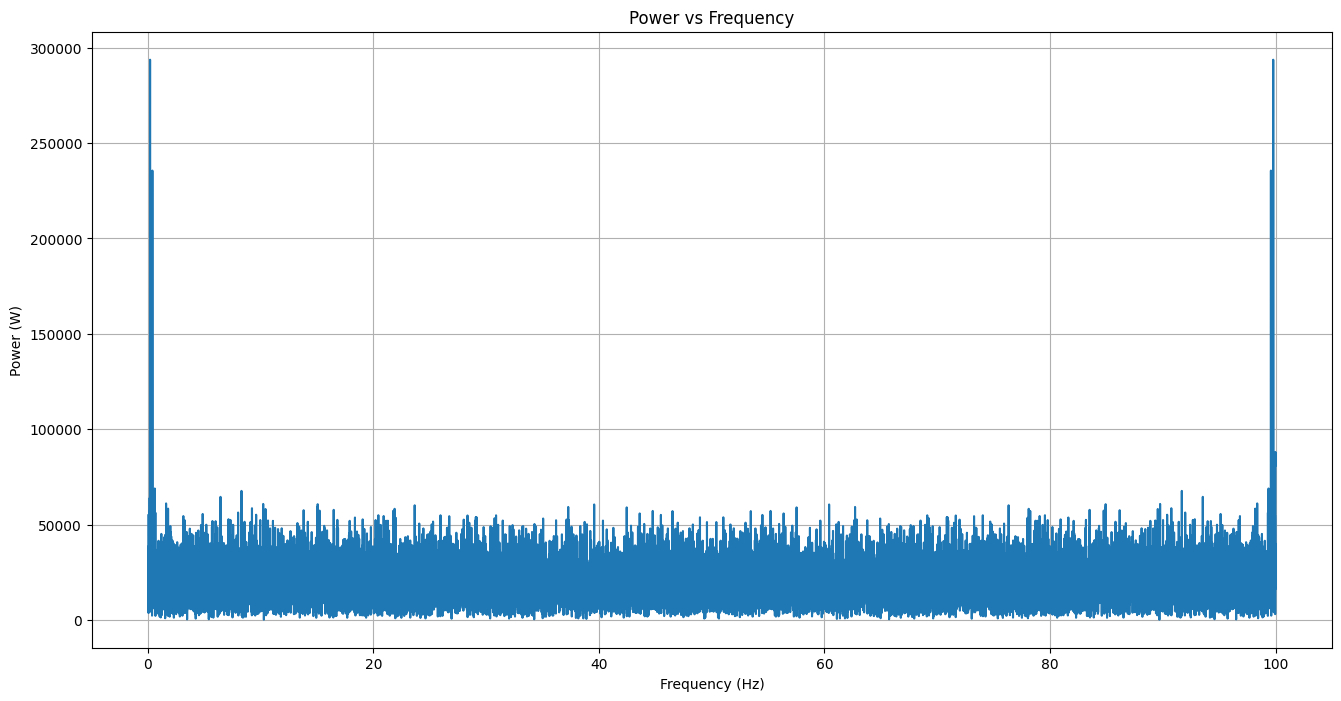

In [222]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(frequency[10:],power[10:])

plt.title('Power vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (W)')
# plt.xlim(0,0.01)
plt.grid()

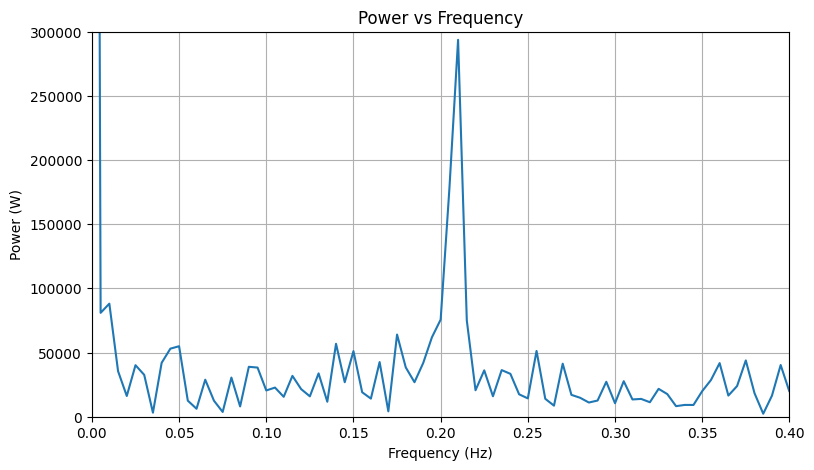

In [223]:
plt.figure(figsize=(9,5))
plt.plot(frequency,power)
plt.ylim(0,300000)
plt.title('Power vs Frequency')
plt.xlim(0,0.4)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (W)')
plt.grid()

We will try to find the highest power which is not the last one as the last one is noise so we shall consider the second last value

In [224]:
sorted(power)[-2]

293679.6693648881

In [225]:
#Trying to get the frequency associated with this power
np.where(power == 293679.6693648881)

(array([   42, 19958], dtype=int64),)

The time period of this pulsar is:

In [226]:
period=1/frequency[42]
period

4.762011407386689

Let's bin and fold the profile to recover pulsar

In [227]:
def fold_light_curve(time, rate, period, nbins=32):
    # Compute phase
    phase = (time % period) / period  # Normalize to [0, 1)

    # Define bins
    bin_edges = np.linspace(0, 1, nbins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    folded_counts = np.zeros(nbins)

    # Bin the data
    indices = np.digitize(phase, bin_edges) - 1
    for i in range(nbins):
        bin_values = rate[indices == i]
        if bin_values.size > 0:
            folded_counts[i] = bin_values.mean()

    # Repeat for two cycles
    two_cycle_phase = np.concatenate([bin_centers, bin_centers + 1])
    two_cycle_counts = np.concatenate([folded_counts, folded_counts])

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(two_cycle_phase, two_cycle_counts, drawstyle='steps-mid', lw=2)
    plt.xlabel('Phase (2 cycles)')
    plt.ylabel('Mean Rate')
    plt.title(f'Folded Light Curve (P = {period:.6f} s)')
    plt.grid(True)
    plt.xlim(0, 2)
    plt.show()
    return bin_centers, folded_counts


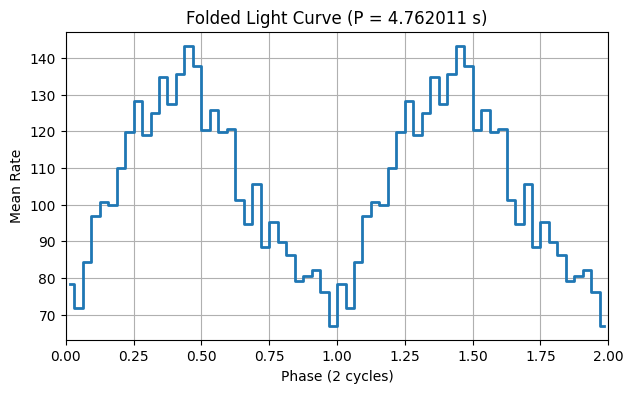

(array([0.015625, 0.046875, 0.078125, 0.109375, 0.140625, 0.171875,
        0.203125, 0.234375, 0.265625, 0.296875, 0.328125, 0.359375,
        0.390625, 0.421875, 0.453125, 0.484375, 0.515625, 0.546875,
        0.578125, 0.609375, 0.640625, 0.671875, 0.703125, 0.734375,
        0.765625, 0.796875, 0.828125, 0.859375, 0.890625, 0.921875,
        0.953125, 0.984375]),
 array([ 78.23264313,  71.77866364,  84.47857666,  96.816185  ,
        100.70635223,  99.77215576, 109.84819031, 119.69098663,
        128.25708008, 118.88815308, 124.88137054, 134.6668396 ,
        127.45491791, 135.70709229, 143.32232666, 137.81967163,
        120.23120117, 125.80845642, 119.74645233, 120.7396698 ,
        101.28804779,  94.70239258, 105.48407745,  88.34679413,
         95.30789948,  89.84997559,  86.21232605,  79.28151703,
         80.55252075,  82.28874969,  76.18752289,  66.97086334]))

In [230]:
# Assuming you have 'time' and 'rate' arrays
fold_light_curve(time, rate, period, nbins=32)

How the Cen X-3 profile actually looks

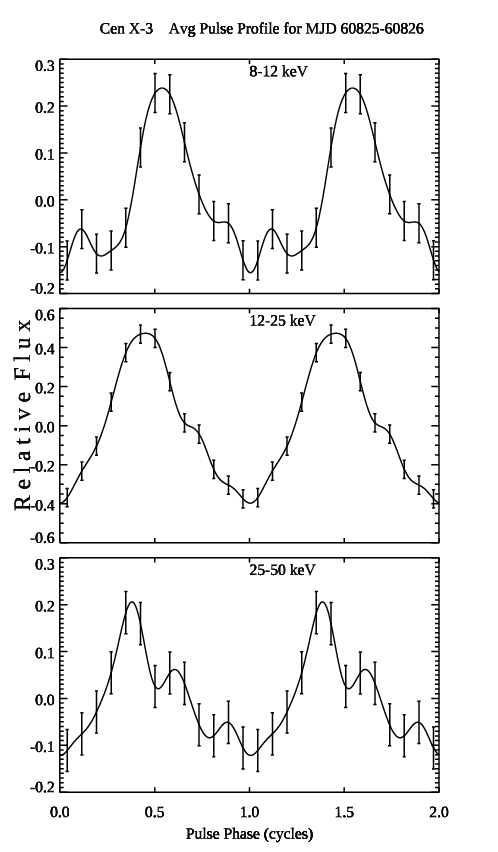

People in pulsar analysis for X-ray also use packages like Stingray in python

https://docs.stingray.science/en/stable/

 or dedicated softwares like HeaSOFT